### Amazon product Review Analysis Project - **Natural Language Processing**

#### The project is divided into 4 subdivision
* **Sentiment Analysis** 
* **Finding the product name from the text using nlp**
* **Time Series analysis to find the trend of sentiments**
* **FInding the relationship between the two categorical data**

#### Installing the **required modules**

In [ ]:
!pip install tqdm
!pip install transformers
!conda install pytorch torchvision torchaudio cpuonly -c pytorch
!pip install -U scikit-learn
!pip install vaderSentiment
!pip install stanfordnlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 11.3 MB/s 
     |████████████████████████████████| 6.6 MB 58.2 MB/s 
     |████████████████████████████████| 120 kB 57.8 MB/s 
/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 27.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 158 kB 22.7 MB/s 


#### **Importing the data**

* The **dataset** is from the **amazon review dataset** 
* The data contains 3,20,000 data for the Health and nearly 2,50,000 data for the sports
* Initially the analysis is **done separately** for both the categories
* The following the libraries are used to do the analysis 

In [ ]:
# Data Manupulation
import os
import pandas as pd
import numpy as np
import glob
import json
import torch


# ML Models
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

# Vader Centiments
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Stop Words and Lematization
import nltk
from nltk.corpus import stopwords
import spacy
from collections import Counter
from nltk.stem import WordNetLemmatizer
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 28034256
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


# Transformer
import transformers
from transformers import BertForSequenceClassification,BertTokenizer,AutoTokenizer,TFAutoModelForSequenceClassification
from transformers.models.auto.modeling_auto import AutoModelForSequenceClassification
from transformers import pipeline

# Resampling
from sklearn.utils import resample

# Regular-Expression
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import metrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def get_df_json(file_path): 
    
    file=glob.glob(file_path)
    review=[]
    with open(file[0]) as data_file:
        data=data_file.read()
        for i in data.split('\n'):
            review.append(i)

    # Making a list of Tuples containg all the data of json files.
    reviewDataframe=[]
    for x in review:
        try:
            jdata=json.loads(x)
            reviewDataframe.append((jdata['reviewerID'],jdata['asin'],jdata['reviewerName'],jdata['helpful'][0],jdata['helpful'][1],jdata['reviewText'],jdata['overall'],jdata['summary'],jdata['unixReviewTime'],jdata['reviewTime'])) 
        except:
            pass        

    # Creating a dataframe using the list of Tuples got in the previous step.    
    data=pd.DataFrame(reviewDataframe,columns=['reviewer_id','product_id','reviewer_name','helpful_vote','total_votes','review_text','rating','summary','unix_review_time','review_time'])
    return data

#### Interpretation:
* We are using **Health and Sports** data for this Project
* Now the data has been imported. **The length of the total data is about 6 lakh data**

In [ ]:
# For health 
data_health = get_df_json('/content/drive/MyDrive/Capstone/Health_and_Personal_Care_5.json')
data_health.head()

,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,review_text,rating,summary,unix_review_time,review_time
0,ALC5GH8CAMAI7,159985130X,AnnN,1,1,This is a great little gadget to have around. ...,5.0,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""",1,1,I would recommend this for a travel magnifier ...,4.0,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""",75,77,What I liked was the quality of the lens and t...,4.0,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,56,60,Love the Great point light pocket magnifier! ...,4.0,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,1,1,This is very nice. You pull out on the magnifi...,5.0,Very nice and convenient.,1313452800,"08 16, 2011"


In [ ]:
# Understanding the features 
data_health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343304 entries, 0 to 343303
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   reviewer_id       343304 non-null  object 
 1   product_id        343304 non-null  object 
 2   reviewer_name     343304 non-null  object 
 3   helpful_vote      343304 non-null  int64  
 4   total_votes       343304 non-null  int64  
 5   review_text       343304 non-null  object 
 6   rating            343304 non-null  float64
 7   summary           343304 non-null  object 
 8   unix_review_time  343304 non-null  int64  
 9   review_time       343304 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 26.2+ MB


#### There are **no null values in the data**


In [ ]:
# Understanding the Datatypes in df
data_health.dtypes

reviewer_id          object
product_id           object
reviewer_name        object
helpful_vote          int64
total_votes           int64
review_text          object
rating              float64
summary              object
unix_review_time      int64
review_time          object
dtype: object

In [ ]:
# Grouping the data based on the Ratings

data_health['rating'].value_counts()

5.0    209697
4.0     67640
3.0     33004
2.0     16606
1.0     16357
Name: rating, dtype: int64

In [ ]:
# Randomly sampling the data to 25000

no_sample = 25000
df_h = data_health.sample(no_sample,replace=False,random_state=42)

df_h.head()

,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,review_text,rating,summary,unix_review_time,review_time
279591,A18SNZN6Z16NCV,B00806TZ2K,"Amazon Customer ""Myrna""",0,0,I am very satisfied with this product. I proba...,5.0,"Great Price, Works Fine",1392854400,"02 20, 2014"
22819,A22I670VTEZKUV,B0002I6PZE,"Kristi Brown ""kbb""",0,0,I specifically purchased this item for my daug...,2.0,Supposed to taste good...,1366070400,"04 16, 2013"
76836,A1RWHDWP5Z3O6R,B000Q6UPYE,MS,3,4,I bought this for my husband and he loves it -...,5.0,Awesome Shaver,1199664000,"01 7, 2008"
216883,A8T6DPNZ7T0VX,B0044EV0SE,"Reality Based Skeptic ""pwillow1""",0,0,I had used liquid Charlie's Soap as a househol...,5.0,Awesome detergent,1320019200,"10 31, 2011"
549,A1QUAHJ3P9Z32T,B00004OCL3,Catherine L.,0,0,well designed;easy on hands; effective,5.0,easy on hands,1404950400,"07 10, 2014"


#### The entire data is reduced to **25000 data** to reduce the processing time.

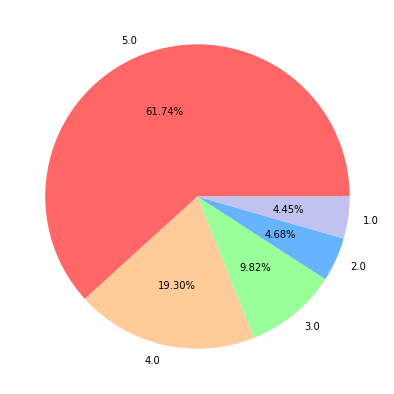

In [ ]:
# Pie Charts of Income_Bracket
fig,ax = plt.subplots(figsize=(15,7))
data = df_h['rating'].value_counts()
label = data.keys()

plt.pie(data,labels=label,autopct='%.2f%%',colors = ['#ff6666', '#ffcc99', '#99ff99', '#66b3ff','#c2c2f0'])
plt.show()

#### **Interpretation:**
* There are more number of **5 rating(Excellent)** product than other categories 
* The data has **less number of 1.0 (awful rating) than other categories**

#### **Data Preprocessing**

* All the **symbols, individual numbers and the spaces** is removed from the data 

In [ ]:
df_h.isnull().sum()

reviewer_id         0
product_id          0
reviewer_name       0
helpful_vote        0
total_votes         0
review_text         0
rating              0
summary             0
unix_review_time    0
review_time         0
dtype: int64

#### **There is no nan datapoints in the data**

In [ ]:
def clean_text(text):
    # Remove all non-letters and non-spaces except for hyphens and digits
    text = re.sub("[^0-9A-Za-z\- ]+", " ", text)
    # Remove all numbers except those attached to a word
    text = re.sub("(?<!\w)\d+", "", text)
    # Remove all hyphens except between two words
    text = re.sub("-(?!\w)|(?<!\w)-", "", text)
    # Remove multiple spaces and lowercase everything
    text = " ".join(text.split())
    text = text.lower()

    return text

df_h['review_text'] = df_h['review_text'].apply(clean_text)
df_h['summary'] = df_h['summary'].apply(clean_text)

df_h.head()

,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,review_text,rating,summary,unix_review_time,review_time
279591,A18SNZN6Z16NCV,B00806TZ2K,"Amazon Customer ""Myrna""",0,0,i am very satisfied with this product i probab...,5.0,great price works fine,1392854400,"02 20, 2014"
22819,A22I670VTEZKUV,B0002I6PZE,"Kristi Brown ""kbb""",0,0,i specifically purchased this item for my daug...,2.0,supposed to taste good,1366070400,"04 16, 2013"
76836,A1RWHDWP5Z3O6R,B000Q6UPYE,MS,3,4,i bought this for my husband and he loves it i...,5.0,awesome shaver,1199664000,"01 7, 2008"
216883,A8T6DPNZ7T0VX,B0044EV0SE,"Reality Based Skeptic ""pwillow1""",0,0,i had used liquid charlie s soap as a househol...,5.0,awesome detergent,1320019200,"10 31, 2011"
549,A1QUAHJ3P9Z32T,B00004OCL3,Catherine L.,0,0,well designed easy on hands effective,5.0,easy on hands,1404950400,"07 10, 2014"


#### **Interpretation:**
* The above function will **clean all the numerical data**
* **It removes all the unneccesary spaces in the text data**
* It also removes all the **symbols in the text**
* And makes **all the data to lower for analysis**

#### Removing **StopWords** 

In [ ]:
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

df_h['review_text'] = df_h['review_text'].apply(lambda words: ' '.join(lemmatizer.lemmatize(word) for word in words.split() if word not in stop))
df_h['review_text'][:5]

279591    satisfied product probably could bought store ...
22819     specifically purchased item daughter supposed ...
76836     bought husband love definitely recommend every...
216883    used liquid charlie soap household cleaner qui...
549                       well designed easy hand effective
Name: review_text, dtype: object

#### **Lematization**

In [ ]:
df_h['summary'] = df_h['summary'].apply(lambda words: ' '.join(lemmatizer.lemmatize(word) for word in words.split() if word not in stop))
df_h['summary'][:5]

279591    great price work fine
22819       supposed taste good
76836            awesome shaver
216883        awesome detergent
549                   easy hand
Name: summary, dtype: object

#### **Interpretation:**
* Now we are removing all the **stopwords using spacy library**
* **The stopwords wont any value to the analysis, since it doesnt have any semantic weightage**
* FOllowed by this is the **leamtization process to get the root word(with useful meaning)**
* The lematization is done using the **nltk lematizer**



#### **Combining Review text and summary** into single column

In [ ]:
# Combining Review and summary into one column
df_h['txt']=df_h['review_text'].astype(str) + df_h['summary'].astype(str)

In [ ]:
df_h.head()

,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,review_text,rating,summary,unix_review_time,review_time,txt
279591,A18SNZN6Z16NCV,B00806TZ2K,"Amazon Customer ""Myrna""",0,0,satisfied product probably could bought store ...,5.0,great price work fine,1392854400,"02 20, 2014",satisfied product probably could bought store ...
22819,A22I670VTEZKUV,B0002I6PZE,"Kristi Brown ""kbb""",0,0,specifically purchased item daughter supposed ...,2.0,supposed taste good,1366070400,"04 16, 2013",specifically purchased item daughter supposed ...
76836,A1RWHDWP5Z3O6R,B000Q6UPYE,MS,3,4,bought husband love definitely recommend every...,5.0,awesome shaver,1199664000,"01 7, 2008",bought husband love definitely recommend every...
216883,A8T6DPNZ7T0VX,B0044EV0SE,"Reality Based Skeptic ""pwillow1""",0,0,used liquid charlie soap household cleaner qui...,5.0,awesome detergent,1320019200,"10 31, 2011",used liquid charlie soap household cleaner qui...
549,A1QUAHJ3P9Z32T,B00004OCL3,Catherine L.,0,0,well designed easy hand effective,5.0,easy hand,1404950400,"07 10, 2014",well designed easy hand effectiveeasy hand


In [ ]:
df = df_h.copy()
df.drop(columns = ['review_text','summary'],inplace=True)
df.head()

,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,rating,unix_review_time,review_time,txt
279591,A18SNZN6Z16NCV,B00806TZ2K,"Amazon Customer ""Myrna""",0,0,5.0,1392854400,"02 20, 2014",satisfied product probably could bought store ...
22819,A22I670VTEZKUV,B0002I6PZE,"Kristi Brown ""kbb""",0,0,2.0,1366070400,"04 16, 2013",specifically purchased item daughter supposed ...
76836,A1RWHDWP5Z3O6R,B000Q6UPYE,MS,3,4,5.0,1199664000,"01 7, 2008",bought husband love definitely recommend every...
216883,A8T6DPNZ7T0VX,B0044EV0SE,"Reality Based Skeptic ""pwillow1""",0,0,5.0,1320019200,"10 31, 2011",used liquid charlie soap household cleaner qui...
549,A1QUAHJ3P9Z32T,B00004OCL3,Catherine L.,0,0,5.0,1404950400,"07 10, 2014",well designed easy hand effectiveeasy hand


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Capstone/df_after_bert25.csv')
df.head()

,Unnamed: 0,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,rating,unix_review_time,review_time,txt,Senti,senti_txt
0,279591,A18SNZN6Z16NCV,B00806TZ2K,"Amazon Customer ""Myrna""",0,0,5.0,1392854400,"02 20, 2014",satisfied product probably could bought store ...,4 stars,Good
1,22819,A22I670VTEZKUV,B0002I6PZE,"Kristi Brown ""kbb""",0,0,2.0,1366070400,"04 16, 2013",specifically purchased item daughter supposed ...,3 stars,Average
2,76836,A1RWHDWP5Z3O6R,B000Q6UPYE,MS,3,4,5.0,1199664000,"01 7, 2008",bought husband love definitely recommend every...,5 stars,Excellent
3,216883,A8T6DPNZ7T0VX,B0044EV0SE,"Reality Based Skeptic ""pwillow1""",0,0,5.0,1320019200,"10 31, 2011",used liquid charlie soap household cleaner qui...,5 stars,Excellent
4,549,A1QUAHJ3P9Z32T,B00004OCL3,Catherine L.,0,0,5.0,1404950400,"07 10, 2014",well designed easy hand effectiveeasy hand,5 stars,Excellent


#### **Creating the model** for sentiment analysis

### **Vader Sentiment Analysis**

In [ ]:
# VADER sentiment analysis for getting pos, neg and neu.

def sentimental_score(sentence):
    analyzer = SentimentIntensityAnalyzer()
    a = analyzer.polarity_scores(sentence)
    score=a['compound']

    if score >= 0.8:
        return 'Excellent'
    elif (score > 0.4) and (score < 0.8):
        return 'Good'
    elif (score > 0) and (score < 0.4):
        return 'Average'
    elif (score > -0.5) and (score < 0):
        return 'bad'
    elif score <= -0.5:
        return 'awful'

* The polarity score is divided into 5 categories 
* The polarity score is extracted and divided into **Excellent,Good,Average,bad,awful**


In [ ]:
df['Senti_vs'] = df['txt'].apply(lambda x: sentimental_score(x))
df.head()

,Unnamed: 0,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,rating,unix_review_time,review_time,txt,Senti,senti_txt,Senti_vs
0,279591,A18SNZN6Z16NCV,B00806TZ2K,"Amazon Customer ""Myrna""",0,0,5.0,1392854400,"02 20, 2014",satisfied product probably could bought store ...,4 stars,Good,Excellent
1,22819,A22I670VTEZKUV,B0002I6PZE,"Kristi Brown ""kbb""",0,0,2.0,1366070400,"04 16, 2013",specifically purchased item daughter supposed ...,3 stars,Average,Excellent
2,76836,A1RWHDWP5Z3O6R,B000Q6UPYE,MS,3,4,5.0,1199664000,"01 7, 2008",bought husband love definitely recommend every...,5 stars,Excellent,Excellent
3,216883,A8T6DPNZ7T0VX,B0044EV0SE,"Reality Based Skeptic ""pwillow1""",0,0,5.0,1320019200,"10 31, 2011",used liquid charlie soap household cleaner qui...,5 stars,Excellent,Excellent
4,549,A1QUAHJ3P9Z32T,B00004OCL3,Catherine L.,0,0,5.0,1404950400,"07 10, 2014",well designed easy hand effectiveeasy hand,5 stars,Excellent,Excellent


#### Converting the **sentiment into rating**

In [ ]:
df.loc[df['Senti_vs'] == 'Excellent','senti_score_vs'] = 5.0
df.loc[df['Senti_vs'] == 'Good','senti_score_vs'] = 4.0
df.loc[df['Senti_vs'] == 'Average','senti_score_vs'] = 3.0
df.loc[df['Senti_vs'] == 'bad','senti_score_vs'] = 2.0
df.loc[df['Senti_vs'] == 'awful','senti_score_vs'] = 1.0

In [ ]:
df.to_csv('/content/drive/MyDrive/Capstone/df_after_final.csv')

#### Creating Bert
* The bert model is created using the pipeline
* We are using **multilingual model to get the output**
* The **multilingual model gives output in the form of labels**
* **Higher the stars the more positive the sentence** is.......


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Creating Pipeline
clf = pipeline('sentiment-analysis', model = 'nlptown/bert-base-multilingual-uncased-sentiment')

In [ ]:
clf('This is bad')

[{'label': '1 star', 'score': 0.7403604388237}]

In [ ]:
def sentimental_score_bbert(sentence):
    dbert = clf(sentence,truncation=True)
    for s in dbert:
      return s['label']

In [ ]:
df['Senti'] = df['txt'].apply(lambda x: sentimental_score_bbert(x))
df.head()

,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,rating,unix_review_time,review_time,txt,Senti
279591,A18SNZN6Z16NCV,B00806TZ2K,"Amazon Customer ""Myrna""",0,0,5.0,1392854400,"02 20, 2014",satisfied product probably could bought store ...,4 stars
22819,A22I670VTEZKUV,B0002I6PZE,"Kristi Brown ""kbb""",0,0,2.0,1366070400,"04 16, 2013",specifically purchased item daughter supposed ...,3 stars
76836,A1RWHDWP5Z3O6R,B000Q6UPYE,MS,3,4,5.0,1199664000,"01 7, 2008",bought husband love definitely recommend every...,5 stars
216883,A8T6DPNZ7T0VX,B0044EV0SE,"Reality Based Skeptic ""pwillow1""",0,0,5.0,1320019200,"10 31, 2011",used liquid charlie soap household cleaner qui...,5 stars
549,A1QUAHJ3P9Z32T,B00004OCL3,Catherine L.,0,0,5.0,1404950400,"07 10, 2014",well designed easy hand effectiveeasy hand,5 stars


In [ ]:
df.loc[df['senti_txt'] == 'Excellent','senti_score'] = 5.0
df.loc[df['senti_txt'] == 'Good','senti_score'] = 4.0
df.loc[df['senti_txt'] == 'Average','senti_score'] = 3.0
df.loc[df['senti_txt'] == 'bad','senti_score'] = 2.0
df.loc[df['senti_txt'] == 'awful','senti_score'] = 1.0

In [ ]:
df.head()

,Unnamed: 0,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,rating,unix_review_time,review_time,txt,Senti,senti_txt,Senti_vs,senti_score,senti_score_vs
0,279591,A18SNZN6Z16NCV,B00806TZ2K,"Amazon Customer ""Myrna""",0,0,5.0,1392854400,"02 20, 2014",satisfied product probably could bought store ...,4 stars,Good,Excellent,4.0,5.0
1,22819,A22I670VTEZKUV,B0002I6PZE,"Kristi Brown ""kbb""",0,0,2.0,1366070400,"04 16, 2013",specifically purchased item daughter supposed ...,3 stars,Average,Excellent,3.0,5.0
2,76836,A1RWHDWP5Z3O6R,B000Q6UPYE,MS,3,4,5.0,1199664000,"01 7, 2008",bought husband love definitely recommend every...,5 stars,Excellent,Excellent,5.0,5.0
3,216883,A8T6DPNZ7T0VX,B0044EV0SE,"Reality Based Skeptic ""pwillow1""",0,0,5.0,1320019200,"10 31, 2011",used liquid charlie soap household cleaner qui...,5 stars,Excellent,Excellent,5.0,5.0
4,549,A1QUAHJ3P9Z32T,B00004OCL3,Catherine L.,0,0,5.0,1404950400,"07 10, 2014",well designed easy hand effectiveeasy hand,5 stars,Excellent,Excellent,5.0,5.0


#### Comparing both the models **Vader And BERT**

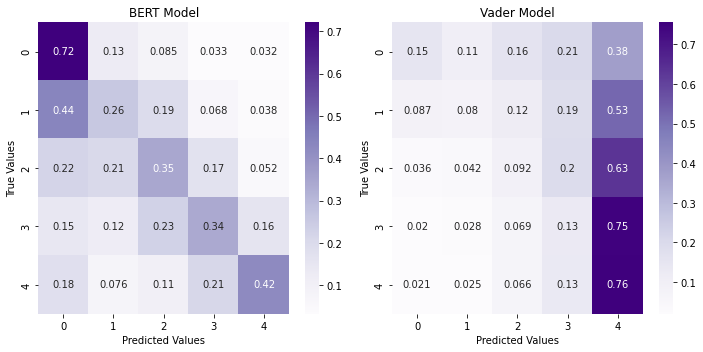

In [ ]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize = (10,5))

# Bert 
cf = metrics.confusion_matrix(df.rating, df.senti_score,normalize= 'true')
sb.heatmap(cf, annot=True, cmap='Purples',ax=ax1,)
ax1.set_title('BERT Model')
ax1.set(xlabel='Predicted Values', ylabel='True Values')

# Bert 
cf = metrics.confusion_matrix(df.rating, df.senti_score_vs,normalize= 'true')
sb.heatmap(cf, annot=True, cmap='Purples',ax=ax2)
ax2.set_title('Vader Model')
ax2.set(xlabel='Predicted Values', ylabel='True Values')

plt.tight_layout()
plt.show()

#### Interpretatation:
* **The number rightly predicted data is high for the bert model than the Vader model**
* **The vader model has good prediction for excellent category but **has very bad prediction for other categories**
* Hence **we can use the output from the bert model for further analysis**

In [ ]:
df['Senti'].value_counts()

5 stars    7507
4 stars    5471
1 star     5365
3 stars    3936
2 stars    2721
Name: Senti, dtype: int64

In [ ]:
df.head()

,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,rating,unix_review_time,review_time,txt,Senti,senti_txt
279591,A18SNZN6Z16NCV,B00806TZ2K,"Amazon Customer ""Myrna""",0,0,5.0,1392854400,"02 20, 2014",satisfied product probably could bought store ...,4 stars,Good
22819,A22I670VTEZKUV,B0002I6PZE,"Kristi Brown ""kbb""",0,0,2.0,1366070400,"04 16, 2013",specifically purchased item daughter supposed ...,3 stars,Average
76836,A1RWHDWP5Z3O6R,B000Q6UPYE,MS,3,4,5.0,1199664000,"01 7, 2008",bought husband love definitely recommend every...,5 stars,Excellent
216883,A8T6DPNZ7T0VX,B0044EV0SE,"Reality Based Skeptic ""pwillow1""",0,0,5.0,1320019200,"10 31, 2011",used liquid charlie soap household cleaner qui...,5 stars,Excellent
549,A1QUAHJ3P9Z32T,B00004OCL3,Catherine L.,0,0,5.0,1404950400,"07 10, 2014",well designed easy hand effectiveeasy hand,5 stars,Excellent


In [ ]:
# Convert the data into csv file
# df.to_csv('/content/drive/MyDrive/Capstone/df_after_bert25.csv')

#### Interpretation:
* Here you can see the **difference between vader and neural network model**
* The **sentiment of the sentence is predicted very well**

# Problem Statement 1.3 

#### Finding the reason for the negative sentiment

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Capstone/df_after_final.csv')

In [ ]:
# !pip install stanza

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
import stanfordnlp
import stanza

**Lets Take only the lowest value score(Bad)**

In [ ]:
df_bad = df.loc[(df.senti_txt == 'awful') & (df.rating == 1.0)]
df_bad.head()

,Unnamed: 0,Unnamed: 0.1,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,rating,unix_review_time,review_time,txt,Senti,senti_txt,Senti_vs,senti_score_vs,senti_score
53,53,226130,AWXFCMX1ERS6N,B004H5D40W,A. McConnell,0,0,1.0,1347926400,"09 18, 2012",product clean foot coordinated stick bottom tu...,1 star,awful,Good,4.0,1.0
54,54,279413,A2THW9X5S48IUA,B007ZRZSR6,PrueC,2,2,1.0,1354147200,"11 29, 2012",edit change review irrigator lasted couple wee...,1 star,awful,NaN,NaN,1.0
162,162,251918,AYGTAE53SCMSU,B005HSW33C,DG,4,4,1.0,1330905600,"03 5, 2012",purchased chamberlain garage door remote origi...,1 star,awful,Average,3.0,1.0
245,245,18959,A1D8ND2ES00NJG,B00024D1HS,PerpetualLearner,42,95,1.0,1345161600,"08 17, 2012",number study efficacy echinacea treating cold ...,1 star,awful,Excellent,5.0,1.0
266,266,198900,AO1DQTD64TD85,B003IGPDQO,Curlcue,2,2,1.0,1394582400,"03 12, 2014",fooled extra wording mg stuff buy half price a...,1 star,awful,Average,3.0,1.0


In [ ]:
a = df_bad.product_id.value_counts()[1]
a

3

#### Now taking only the products having high number of negative sentiments

In [ ]:
df_bad = df_bad.loc[df_bad.product_id =='B001DKWLDK']
df_bad.head()

,Unnamed: 0,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,rating,unix_review_time,review_time,txt,Senti,senti_txt
3103,123080,A1QTICTBQKS6I6,B001DKWLDK,No Name,1,2,1.0,1328659200,"02 8, 2012",know antiperspirant expecting stop sweating ex...,1 star,awful
10078,123075,A230CAH5O7B9FQ,B001DKWLDK,Melissa,1,2,1.0,1243814400,"06 1, 2009",natural aluminum free deodorant excited hopefu...,1 star,awful
14095,123071,A4TK8ENW87B41,B001DKWLDK,Lila Klu,0,1,1.0,1326240000,"01 11, 2012",really disappointed deodorant barely scent abs...,1 star,awful
19710,123061,ANFFK43JM31BZ,B001DKWLDK,"I. Newton ""Miss Ginger""",0,0,1.0,1390003200,"01 18, 2014",bought wanted try something natural nothing od...,1 star,awful


In [ ]:
txt = ' '.join(t for t in df_bad.txt[:1])
txt

'know antiperspirant expecting stop sweating expect would mask smell sweat show given try mask anything actually smell worse total garbage thought smelled nice tubesmell nice smell awful'

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
import stanfordnlp

# Make sure you have downloaded the StanfordNLP English model and other essential tools using,
# stanfordnlp.download('en')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

def aspect_sentiment_analysis(txt, stop_words, nlp):
    
    txt = txt.lower() # LowerCasing the given Text
    sentList = nltk.sent_tokenize(txt) # Splitting the text into sentences
    
    fcluster = []
    totalfeatureList = []
    finalcluster = []
    dic = {}

    for line in sentList:
        newtaggedList = []
        txt_list = nltk.word_tokenize(line) # Splitting up into words
        taggedList = nltk.pos_tag(txt_list) # Doing Part-of-Speech Tagging to each word

        newwordList = []
        flag = 0
        for i in range(0,len(taggedList)-1):
            if(taggedList[i][1]=="NN" and taggedList[i+1][1]=="NN"): # If two consecutive words are Nouns then they are joined together
                newwordList.append(taggedList[i][0]+taggedList[i+1][0])
                flag=1
            else:
                if(flag==1):
                    flag=0
                    continue
                newwordList.append(taggedList[i][0])
                if(i==len(taggedList)-2):
                    newwordList.append(taggedList[i+1][0])

        finaltxt = ' '.join(word for word in newwordList) 
        new_txt_list = nltk.word_tokenize(finaltxt)
        wordsList = [w for w in new_txt_list if not w in stop_words]
        taggedList = nltk.pos_tag(wordsList)

        doc = nlp(finaltxt) # Object of Stanford NLP Pipeleine
        
        # Getting the dependency relations betwwen the words
        dep_node = []
        for dep_edge in doc.sentences[0].dependencies:
          dep_node.append([dep_edge[2].text, dep_edge[0].id, dep_edge[1]])

        # Coverting it into appropriate format
        for i in range(0, len(dep_node)):
            if (int(dep_node[i][1]) != 0):
                dep_node[i][1] = newwordList[(int(dep_node[i][1]) - 1)]

        featureList = []
        categories = []
        for i in taggedList:
            if(i[1]=='JJ' or i[1]=='NN' or i[1]=='JJR' or i[1]=='NNS' or i[1]=='RB'):
                featureList.append(list(i)) # For features for each sentence
                totalfeatureList.append(list(i)) # Stores the features of all the sentences in the text
                categories.append(i[0])

        for i in featureList:
            filist = []
            for j in dep_node:
                if((j[0]==i[0] or j[1]==i[0]) and (j[2] in ["nsubj", "acl:relcl", "obj", "dobj", "agent", "advmod", "amod", "neg", "prep_of", "acomp", "xcomp", "compound"])):
                    if(j[0]==i[0]):
                        filist.append(j[1])
                    else:
                        filist.append(j[0])
            fcluster.append([i[0], filist])
            
    for i in totalfeatureList:
        dic[i[0]] = i[1]
    
    for i in fcluster:
        if(dic[i[0]]=="NN"):
            finalcluster.append(i)
        
    return(finalcluster)


nlp = stanza.Pipeline() # Initialize the pipeline using a configuration dict
txt = ' '.join(t for t in df_bad.txt[:1])
stop_words = set(stopwords.words('english'))
print(aspect_sentiment_analysis(txt, stop_words, nlp))


INFO:stanza:Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: constituency
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


[['expect', ['stopsweating', 'expecting']], ['garbage', ['thought']]]


#### Understanding which words contributed to negativity of the sentence using **word cloud**

In [ ]:
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
wc=WordCloud(width=1000, height=600,stopwords=stop_words)

In [ ]:
# Extracting the data from text column
txt = ' '.join(t for t in df_bad.txt)
txt

'know antiperspirant expecting stop sweating expect would mask smell sweat show given try mask anything actually smell worse total garbage thought smelled nice tubesmell nice smell awful natural aluminum free deodorant excited hopeful bought one first worked well within week under-arm skinned dark brown burned skin peeled showered under-arms hurt hour afterward deodorant smelled good first applied within hour ineffective re-apply since switched deodorant crystal extremely pleasedwork discolored skin really disappointed deodorant barely scent absolutely nothing deodorize say long last even begin workapplied liberally straight toweling dry shower going back arm hammer fresh scent aluminum free stick even though tired scentbarely bought wanted try something natural nothing odor protection smell like sweat apricot went back degree daybetter nothing'

In [ ]:
wc.generate(txt)

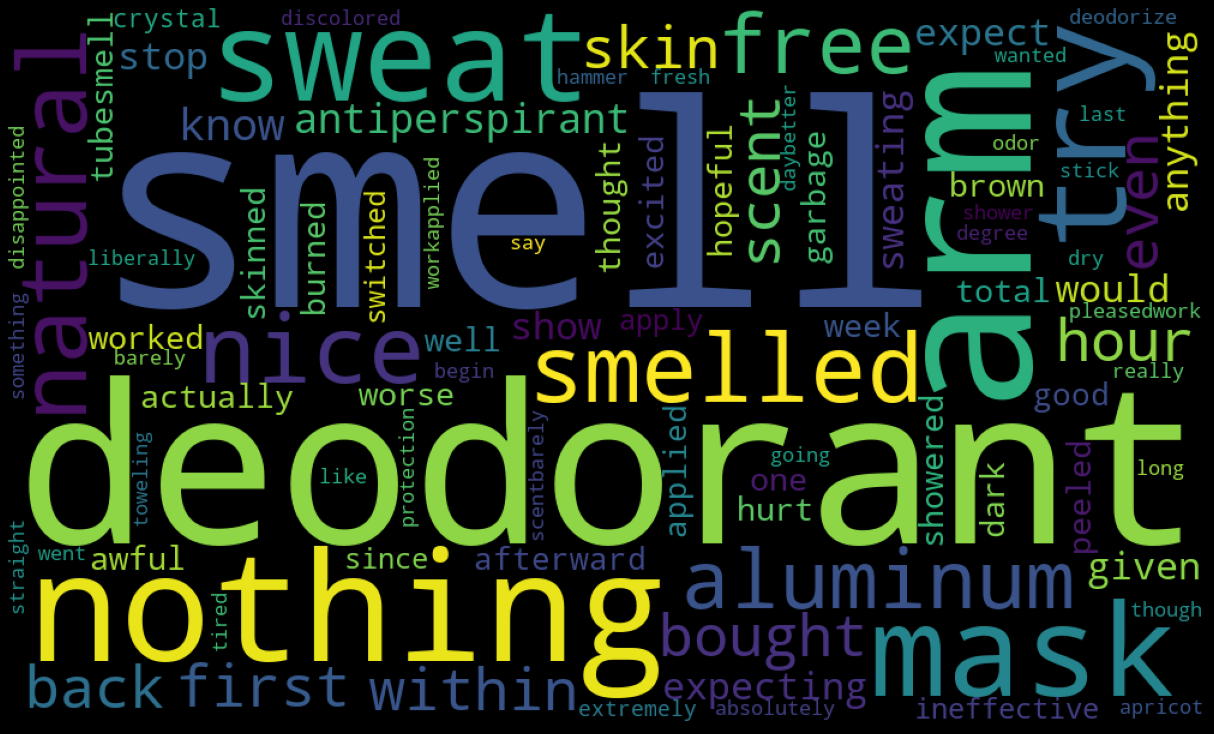

In [ ]:
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
df_good = df.loc[(df.senti_txt == 'Excellent')]
df_good.head()

,Unnamed: 0,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,rating,unix_review_time,review_time,txt,Senti,senti_txt
2,76836,A1RWHDWP5Z3O6R,B000Q6UPYE,MS,3,4,5.0,1199664000,"01 7, 2008",bought husband love definitely recommend every...,5 stars,Excellent
3,216883,A8T6DPNZ7T0VX,B0044EV0SE,"Reality Based Skeptic ""pwillow1""",0,0,5.0,1320019200,"10 31, 2011",used liquid charlie soap household cleaner qui...,5 stars,Excellent
4,549,A1QUAHJ3P9Z32T,B00004OCL3,Catherine L.,0,0,5.0,1404950400,"07 10, 2014",well designed easy hand effectiveeasy hand,5 stars,Excellent
9,78333,A2XM1C766VYUAG,B000QYEK88,Charles Roderick,0,0,5.0,1395100800,"03 18, 2014",never used double edge dx razor although fathe...,5 stars,Excellent
17,192052,A3V4OD9WI97PEX,B0038QQ7RI,Jujusmommie,0,0,5.0,1390089600,"01 19, 2014",bought product alcohol free ketokid one approv...,5 stars,Excellent


In [ ]:
df_good.product_id.value_counts()

B0010JLMO8    31
B0037KMI0U    28
B001F51VRK    17
B0032TNPOE    16
B000GIPJY8    16
              ..
B005VSXUQM     1
B00AE2TJX8     1
B000N4N4UG     1
B00172HEAY     1
B00CM2FLWG     1
Name: product_id, Length: 4922, dtype: int64

In [ ]:
df_good = df_good.loc[(df_good.product_id =='B0010JLMO8') ]
df_good.head()

,Unnamed: 0,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,rating,unix_review_time,review_time,txt,Senti,senti_txt
824,93236,A5S38CUDPMJ3H,B0010JLMO8,"P. Breeds ""Amazon woman""",0,0,5.0,1345248000,"08 18, 2012",use blender ball go bottle liked much bought f...,5 stars,Excellent
1566,93319,A34G3Y755YCRAX,B0010JLMO8,S. E. Valle,0,0,5.0,1362700800,"03 8, 2013",wish would bought product long time ago mix pr...,5 stars,Excellent
2943,92935,A4YA9F6TSNEZ4,B0010JLMO8,fixitbroken,0,0,5.0,1396224000,"03 31, 2014",bottle blend great size mix shake well clean q...,5 stars,Excellent
3748,93212,ATT5Y8EO55PJG,B0010JLMO8,Nichole,0,0,5.0,1367625600,"05 4, 2013",perfect size protien shake little le would pay...,5 stars,Excellent
3825,92682,A19LEE1KU5Q16E,B0010JLMO8,Alex,0,0,5.0,1357516800,"01 7, 2013",start intended use blender ball excellent mixi...,5 stars,Excellent


In [ ]:
# Extracting the data from text column
txt = ' '.join(t for t in df_good.txt[:5])
txt

'use blender ball go bottle liked much bought four gave one mother take ice tea go cap snap snugly add lemonade mix ice shake away large size help get glass fluid easily like slim tapered design well easy holdgreat bottle wish would bought product long time ago mix protein powder perfectly never get clump like try stirring shake spoon actually create real protein shake recommendgreatness bottle blend great size mix shake well clean quickly use whey creatine shake work greatmixer nice bought twice perfect size protien shake little le would pay store fantastic buylove start intended use blender ball excellent mixing drink top never leak ball good job mixing size appropriate however like drinking take ball put beverage milk water whatever thing need mixing like measurement side even counting calorie nice visually see drinking oz x great bottle decent price great shipping amazongood protein shake'

In [ ]:
wc.generate(txt)

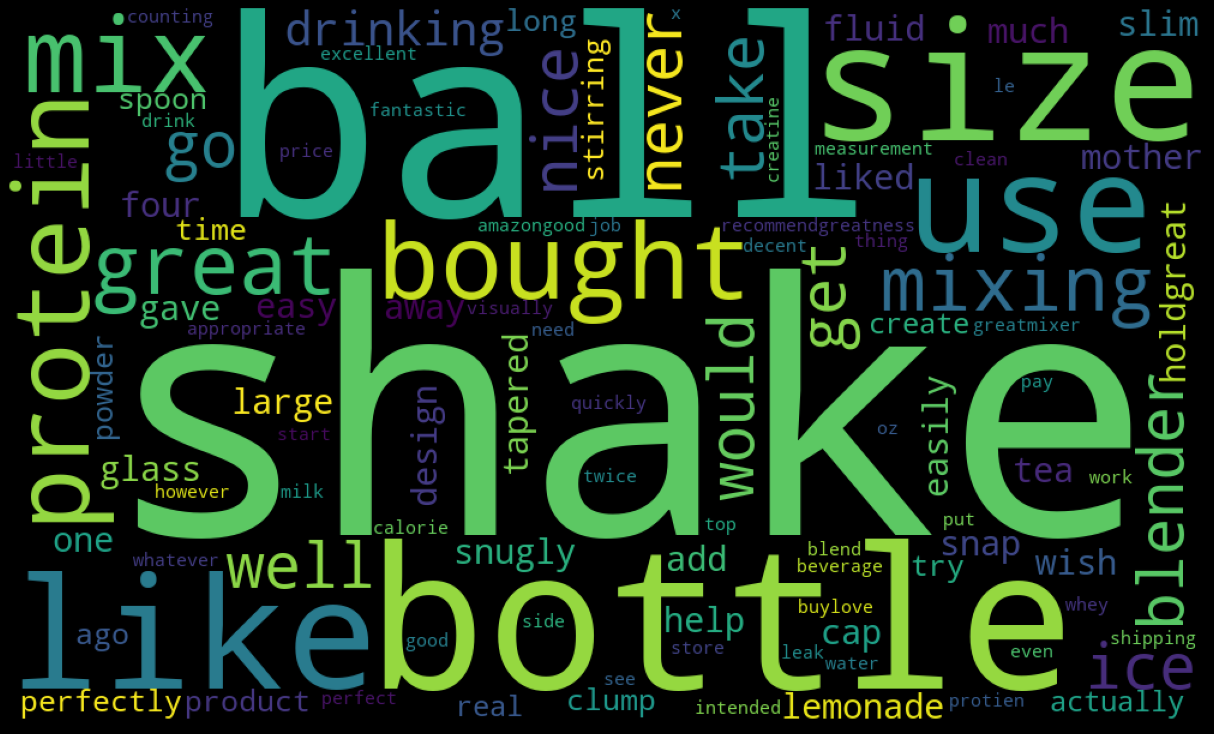

In [ ]:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Problem Statement 2 Finding the product name using **Named Entity Recognition**[link text](https://)

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df.head()

,Unnamed: 0,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,rating,unix_review_time,review_time,txt,Senti,senti_txt
0,279591,A18SNZN6Z16NCV,B00806TZ2K,"Amazon Customer ""Myrna""",0,0,5.0,1392854400,"02 20, 2014",satisfied product probably could bought store ...,4 stars,Good
1,22819,A22I670VTEZKUV,B0002I6PZE,"Kristi Brown ""kbb""",0,0,2.0,1366070400,"04 16, 2013",specifically purchased item daughter supposed ...,3 stars,Average
2,76836,A1RWHDWP5Z3O6R,B000Q6UPYE,MS,3,4,5.0,1199664000,"01 7, 2008",bought husband love definitely recommend every...,5 stars,Excellent
3,216883,A8T6DPNZ7T0VX,B0044EV0SE,"Reality Based Skeptic ""pwillow1""",0,0,5.0,1320019200,"10 31, 2011",used liquid charlie soap household cleaner qui...,5 stars,Excellent
4,549,A1QUAHJ3P9Z32T,B00004OCL3,Catherine L.,0,0,5.0,1404950400,"07 10, 2014",well designed easy hand effectiveeasy hand,5 stars,Excellent


In [ ]:
from tqdm import tqdm
nlp = spacy.load('en_core_web_sm')

In [ ]:
entity = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    for word in nlp(row['txt']).ents:
      entity[row['txt']] = [word.text, word.label_]
print(entity)

100%|██████████| 25000/25000 [04:47<00:00, 86.87it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
ent = pd.DataFrame(entity,index=['products','type']).T
ent_prod = ent[(ent['type']=='PRODUCT')][['products']]

In [ ]:
ent_prod.head(15)

,products
need enteric coated tablet since get absolutely gastric problem aspirin true lot people issue need spend waste additional money enteric coating result normally buy enteric coated aspirin added cost however purchased product comparing price amazon darned good deal could saved money buying larger quantity basically enough aspirin year honest despite fact phd pharmacology teach major medical school clue sitting shelf month would pill large batchbayer mg enteric coated aspirin,enteric
heard girl friend heard radio show people chain chatter say felt awesome energy dropped weight w dieting know tasty easy use gross like many vitamin mix fattening good breakfast use half suggested portion give body easy curve nutrient really like glad ordered day noticed kick energy sustained backyum,backyum
another excelent clinical anti-perspirant secret clinical sensitive skin give look clinical anti-perspirant without irritating skin unscented lack sensitive skin product men especially anti-perspirant department perfect either genderpros1 go smooth creamy non-irritating2 unscented hypoallergenic woman anti-perspirant unscented perfect men suffer sensitive skin since lack sensitive skin product men cons1 like clinical anti-perspirant lasting effect difficult wash offclinical protection without irritation scent askwork great irritate,cons1
replacement foil fit old bg2020 new bg2028 fine bought several folk lifespan bg2020 recently chance compare performance new original cutter foil came bg2028 replacement foil bought old bg2020 others reported replacement hands-down better original clearly sharper effective going hair foil essentially new combination subscribe save recent coupon made price reasonable recommendedbetter original part,bg2028
remzzzs helped following1 dont wash mask soap every night2 reduced leak3 muffled mask-fart noiseremzzzs reduce leak,leak3
extremely reasonable price personal desk size tissue box fine generic office tissue kleenex current long-time favorite thinner harsher kleenex regular however also affordable kleenex goal inexpensive reasonable tissue great box varied interesting nice color work fine goal soft tissue look elsewhere hope helpfulreasonable price reasonably soft soft leading brand kleenex favorite,kleenex
needed new battery two kitchen timer price amazon marketplace far better local retailer ordered maxell watch battery button cell lr41 pack battery mistake needed lr44 however price right watch take size battery kept store freezer needed expiration date packaging price willing try needed best price mirror shipped battery quickly via usps arrived le weekgreat price fast shipping,lr44
stunk whole house smelled like kind awful disinfectant relaxing yuck yuck yuck yuckstink,yuck
thorne research virgin diet vanilla ozthorne researchclick star rate iti love posted publicly cleargreat tasting,diet vanilla ozthorne researchclick star
good product like gold product seem work well system recommend product anyone looking good vitamin productd3 gold,productd3


#### Interpretation:
* The some of the above predicted products name can be said as the product but not all the products is predicted very well
* **Hence we can use topic modelling to find out what the text is about and try to get the products**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Capstone/df_after_final.csv')

In [ ]:
df_bad = df.loc[(df.senti_txt == 'awful') & (df.rating == 1.0)]
df_bad.head()

,Unnamed: 0,Unnamed: 0.1,reviewer_id,product_id,reviewer_name,helpful_vote,total_votes,rating,unix_review_time,review_time,txt,Senti,senti_txt,Senti_vs,senti_score_vs,senti_score
53,53,226130,AWXFCMX1ERS6N,B004H5D40W,A. McConnell,0,0,1.0,1347926400,"09 18, 2012",product clean foot coordinated stick bottom tu...,1 star,awful,Good,4.0,1.0
54,54,279413,A2THW9X5S48IUA,B007ZRZSR6,PrueC,2,2,1.0,1354147200,"11 29, 2012",edit change review irrigator lasted couple wee...,1 star,awful,NaN,NaN,1.0
162,162,251918,AYGTAE53SCMSU,B005HSW33C,DG,4,4,1.0,1330905600,"03 5, 2012",purchased chamberlain garage door remote origi...,1 star,awful,Average,3.0,1.0
245,245,18959,A1D8ND2ES00NJG,B00024D1HS,PerpetualLearner,42,95,1.0,1345161600,"08 17, 2012",number study efficacy echinacea treating cold ...,1 star,awful,Excellent,5.0,1.0
266,266,198900,AO1DQTD64TD85,B003IGPDQO,Curlcue,2,2,1.0,1394582400,"03 12, 2014",fooled extra wording mg stuff buy half price a...,1 star,awful,Average,3.0,1.0


In [ ]:
df_bad['product_id'].value_counts()

B001DKWLDK    4
B007MB5YMO    3
B000GAAANG    3
B008YRK7EU    3
B009VUZJTM    3
             ..
B003ATS2QC    1
B003Z67ENC    1
B00EEEFUZI    1
B00G8L58CA    1
B00440EO6S    1
Name: product_id, Length: 754, dtype: int64

In [ ]:
very_bad = df_bad[(df_bad['product_id'] == 'B001DKWLDK') | (df_bad['product_id'] == 'B007MB5YMO') | (df_bad['product_id'] == 'B000GAAANG')]
very_bad = very_bad[['product_id','txt']]
very_bad.set_index('product_id',inplace = True)
very_bad

,txt
product_id,
B000GAAANG,sent item back looked used dirty properly wrap...
B001DKWLDK,know antiperspirant expecting stop sweating ex...
B007MB5YMO,stressful job sometimes tough get sleep night ...
B007MB5YMO,experience take nyquil hour sleep always wake ...
B000GAAANG,listen bought st unit month ago light cable co...
B001DKWLDK,natural aluminum free deodorant excited hopefu...
B007MB5YMO,nothing zzzquil indicates anything different s...
B001DKWLDK,really disappointed deodorant barely scent abs...
B001DKWLDK,bought wanted try something natural nothing od...


In [ ]:
very_bad1 = df_bad[['product_id','txt']]
very_bad1.set_index('product_id',inplace = True)
very_bad1

,txt
product_id,
B004H5D40W,product clean foot coordinated stick bottom tu...
B007ZRZSR6,edit change review irrigator lasted couple wee...
B005HSW33C,purchased chamberlain garage door remote origi...
B00024D1HS,number study efficacy echinacea treating cold ...
B003IGPDQO,fooled extra wording mg stuff buy half price a...
...,...
B001JQLNH8,hold meaning disposable use anyone twice waste...
B000TMFTQE,last month according well known reputable lab ...
B00014DROG,sure much say try another brand also boo amazo...


In [ ]:
!pip install pyabsa
from pyabsa import ATEPCCheckpointManager
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True  # False means load model on CPU
                                   )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 249 kB 31.8 MB/s 
     |████████████████████████████████| 1.3 MB 62.6 MB/s 
     |████████████████████████████████| 181 kB 69.7 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 314 kB 62.8 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pytorch-warmup: filename=pytorch_warmup-0.1.0-py3-none-any.whl size=5802 sha256=f3334fcb52a0e9e377314362515c74a9a2f3f8ae215096afebae718d1b3de951
  Stored in directory: /root/.cache/pip/wheels/c7/5d/24/9475e442daa1e9332c122c79fb5131b9e4e91946009365902e
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=db79ea69bc08c0a37799f2d04a399c6b57de3fd54b7a43f83bde6cd797846f91
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce

/usr/local/lib/python3.7/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


********** Available ATEPC model checkpoints for Version:1.16.14 (this version) **********
----------------------------------------------------------------------------------------------------
Checkpoint Name: english
id: 
Training Model: FAST-LCFS-ATEPC
Training Dataset: English
Language: English
Description: Trained on RTX3090, this checkpoint use bert-spc in ATEPC training
Available Version: 1.16.0+
Checkpoint File: fast_lcf_atepc_English_cdw_apcacc_85.4_apcf1_82.53_atef1_80.19.zip
Author: H, Yang (yangheng@m.scnu.edu.cn)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Checkpoint Name: chinese
id: 
Training Model: FAST-LCF-ATEPC
Training Dataset: Chinese
Language: Chinese
Description: Trained on RTX3090 BERT-BASE-CHINESE
Available Version: 1.16.0+
Checkpoint File: fast_lcf_atepc_Chinese_cdw_apcacc_96.09_apcf1_95.14_atef1_83.69.zip
A

577MB [00:02, 284.43MB/s, Downloading checkpoint...]                         

Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_85.4_apcf1_82.53_atef1_80.19.zip, unzipping...


Done.
If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA-ATEPC/resolve/main/checkpoint/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_85.4_apcf1_82.53_atef1_80.19.zip 
Load aspect extractor from ./checkpoints/ATEPC_ENGLISH_CHECKPOINT
config: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc.config
state_dict: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc.state_dict
model: None
tokenizer: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc.tokenizer


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Config used in Training:
ABSADatasetsVersion:None	-->	Calling Count:0
IOB_label_to_index:{'B-ASP': 1, 'I-ASP': 2, 'O': 3, '[CLS]': 4, '[SEP]': 5}	-->	Calling Count:1
MV:<metric_visualizer.metric_visualizer.MetricVisualizer object at 0x7fb9fe7bf650>	-->	Calling Count:0
PyABSAVersion:1.15.7	-->	Calling Count:0
SRD:3	-->	Calling Count:79070
TorchVersion:1.10.0+cuda11.3	-->	Calling Count:0
TransformersVersion:4.20.1	-->	Calling Count:0
auto_device:True	-->	Calling Count:50569
batch_size:16	-->	Calling Count:5
cache_dataset:True	-->	Calling Count:1
dataset_file:{'train': ['integrated_datasets/atepc_datasets/110.SemEval/113.laptop14/Laptops_Train.xml.seg.atepc', 'integrated_datasets/atepc_datasets/110.SemEval/114.restaurant14/Restaurants_Train.xml.seg.atepc', 'integrated_datasets/atepc_datasets/110.SemEval/116.restaurant16/restaurant_train.raw.atepc', 'integrated_datasets/atepc_datasets/101.ACL_Twitter/acl-14-short-data/train.raw.atepc', 'integrated_datasets/atepc_datasets/109.MAMS/train.xml

In [ ]:
from nltk.tokenize import sent_tokenize

aspect = []
text = []
senti = []
prod = []

c = 0
for i in very_bad1['txt'][:20]:
  c+=1
  a = [i]
  print(i)
  inference_source = a
  atepc_result = aspect_extractor.extract_aspect(inference_source=inference_source,  #
                            pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                            )
  out = atepc_result
  if 'Negative' in out[0]['sentiment']:
    aspect.append(out[0]['aspect'][0])
    senti.append(out[0]['sentiment'][0])
    text.append(i[:50])
    prod.append(very_bad1.index[c])

  if c == 19:
    break
d = pd.DataFrame({'Product':prod,
                  'Text':text,
                  'Aspect':aspect,
                  'Sentiment':senti,
                  })
d
  

product clean foot coordinated stick bottom tub texture bottom stick stick side tub storage without sticking use one foot hold trying move foot back forth creates another problem arch product get way smack bone top foot trying rub back forth pumous stone terrible get way trying get heel clean tough stone end making back heel rough price good true sorrystick surface
The results of aspect term extraction have been saved in /content/atepc_inference.result.json
Example 0: product clean foot coordinated stick bottom <tub texture bottom:Negative Confidence:0.4798814058303833> stick stick side tub storage without sticking use one foot hold trying move foot back forth creates another problem arch product get way smack bone top foot trying rub back forth <pumous stone:Negative Confidence:0.9998500347137451> terrible get way trying get heel clean tough stone end making back heel rough <price:Negative Confidence:0.9965757727622986> good true sorrystick surface
edit change review irrigator lasted 

,Product,Text,Aspect,Sentiment
0,B007ZRZSR6,product clean foot coordinated stick bottom tu...,tub texture bottom,Negative
1,B005HSW33C,edit change review irrigator lasted couple wee...,oral,Negative
2,B00024D1HS,purchased chamberlain garage door remote origi...,garage door remote,Neutral
3,B00AO379SO,fooled extra wording mg stuff buy half price a...,wording,Negative
4,B00099YMB0,trimmer piece garbage wont hold charge long to...,trimmer,Negative
5,B000QYNUX4,use mag flashlight using duracell quantum woul...,battery,Positive
6,B004PB7OTA,like pill force drink water say noticing great...,bottle,Negative
7,B0009STNME,understand pillow got fantastic review smell a...,smell,Negative
8,B00C43H680,grabber useless unless want pick pin good boug...,grabber,Negative
9,B004L9VHTE,absolutely useless product like one made natro...,natrol,Negative
